In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import datetime
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Load Stockmarket Data

In [3]:
sp500 = pd.read_csv("sp500.csv")
spy = pd.read_csv("spy.csv")

In [4]:
sp500.head()

,date,open,high,low,close,close_adj,volume
0,1/18/2012,1293.65,1308.11,1290.99,1308.04,1308.04,4.096160e+09
1,1/19/2012,1308.07,1315.49,1308.07,1314.50,1314.50,4.465890e+09
2,1/20/2012,1314.49,1315.38,1309.17,1315.38,1315.38,3.912620e+09
3,1/23/2012,1315.29,1322.28,1309.89,1316.00,1316.00,3.770910e+09
4,1/24/2012,1315.96,1315.96,1306.06,1314.65,1314.65,3.693560e+09


In [5]:
spy.head()

,date,open,high,low,close,close_adj,volume
0,1/18/2012,129.31,130.84,129.08,130.77,107.98,163395200.0
1,1/19/2012,131.22,131.57,130.80,131.46,108.55,126328900.0
2,1/20/2012,131.24,131.95,130.92,131.95,108.95,138230200.0
3,1/23/2012,131.51,132.25,130.98,131.61,108.67,129295800.0
4,1/24/2012,130.80,131.50,130.60,131.46,108.55,103083300.0


## Verify that the SPY ETF is correlated with the S&P 500
We verify that the data sets are correlated, and as expected we find all features to be perfectly correlated, with exception to volume.

In [6]:
sp500.corrwith(spy)

open         0.999946
high         0.999977
low          0.999981
close        0.999989
close_adj    0.999545
volume       0.512112
dtype: float64

## Feature Engineering

In [7]:
data = spy

In [8]:
data['d1'] = data.close_adj/data.close_adj.shift(1)
data['d2'] = data.close_adj/data.close_adj.shift(2)
data['d3'] = data.close_adj/data.close_adj.shift(3)

In [9]:
data = data.drop([0,1,2])

In [10]:
data.isna().sum()

date         0
open         0
high         0
low          0
close        0
close_adj    0
volume       0
d1           0
d2           0
d3           0
dtype: int64

In [11]:
data

,date,open,high,low,close,close_adj,volume,d1,d2,d3
3,1/23/2012,131.51,132.25,130.98,131.61,108.67,129295800.0,0.997430,1.001105,1.006390
4,1/24/2012,130.80,131.50,130.60,131.46,108.55,103083300.0,0.998896,0.996329,1.000000
5,1/25/2012,131.26,132.87,130.75,132.56,109.45,198613200.0,1.008291,1.007178,1.004589
6,1/26/2012,133.15,133.40,131.36,131.88,108.89,184880500.0,0.994884,1.003132,1.002024
7,1/27/2012,131.24,132.05,131.15,131.82,108.84,135259100.0,0.999541,0.994427,1.002672
...,...,...,...,...,...,...,...,...,...,...
2512,1/10/2022,462.70,465.74,456.60,465.51,465.51,119362000.0,0.998756,0.994807,0.993872
2513,1/11/2022,465.23,469.85,462.05,469.75,469.75,74303100.0,1.009108,1.007853,1.003868
2514,1/12/2022,471.59,473.20,468.94,471.02,471.02,67605400.0,1.002704,1.011836,1.010577
2515,1/13/2022,472.19,472.88,463.44,464.53,464.53,91173100.0,0.986221,0.988888,0.997895


In [12]:
print ("Average 1 day change",data['d1'].mean())
print ("Average 2 day change",data['d2'].mean())
print ("Average 3 day change",data['d3'].mean())

Average 1 day change 1.0006290141455563
Average 2 day change 1.0012442175636804
Average 3 day change 1.0018774869018376


In [13]:
def plot_dist(data, detail=None, n = 100, s=3, ):
    vars_name = data.name
    mu, std = norm.fit(data)
    plt.hist(data, bins = n, density=True, alpha=0.5, color='b')
    xmin, xmax = plt.xlim()
    x = np.linspace(
        start = xmin,
        stop = xmax,
        num = 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    for i in range(1, s+1):
        for j in [1, -1]:
            plt.axvline(
                x = mu + i * j * std, 
                linewidth=.5, 
                color="g",
                linestyle = "-.")
    plt.axvline(x=mu, linewidth=.5, color="r")
    plt.xlim(mu - s*std, mu + s*std)
    plt.legend([f'Mu: {mu:.5f}', f'Std: {std:.5f}'])
    title = f'Distribution of {vars_name}'
    if detail != None:
        title = title+'\n'+detail
    plt.title(title)
  
    return plt.show()

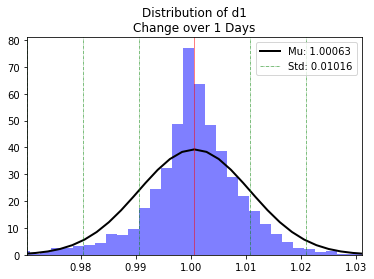

In [14]:
plot_dist(data['d1'], "Change over 1 Days")

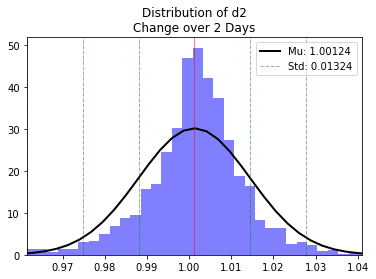

In [15]:
plot_dist(data['d2'], "Change over 2 Days")

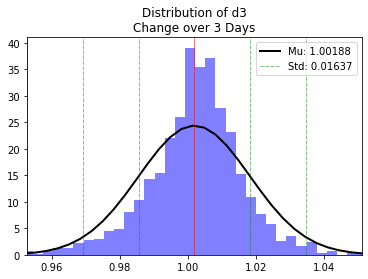

In [16]:
plot_dist(data['d3'], "Change over 3 Days")

In [17]:
def calculate_z(column):
    return (column - column.mean())/np.std(column)

In [18]:
np.std(data['d1'])

0.01015847934240302

In [19]:
data['d1_z'] = calculate_z(data['d1'])
data['d2_z'] = calculate_z(data['d2'])
data['d3_z'] = calculate_z(data['d3'])

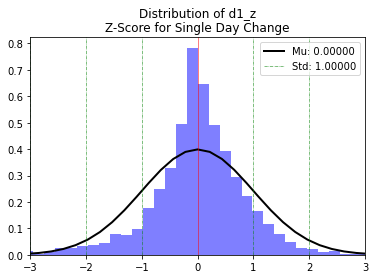

In [20]:
plot_dist(data['d1_z'], "Z-Score for Single Day Change")

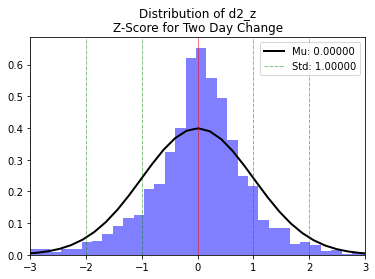

In [21]:
plot_dist(data['d2_z'], "Z-Score for Two Day Change")

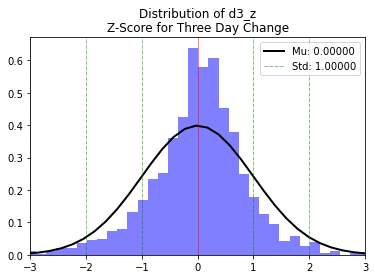

In [22]:
plot_dist(data['d3_z'], "Z-Score for Three Day Change")

### Day Week Month

In [23]:
data['date'] = pd.to_datetime(data['date'])

In [24]:
data['day'] = data['date'].dt.day_name()

In [25]:
data['month'] = data['date'].dt.month_name()

In [26]:
data

,date,open,high,low,close,close_adj,volume,d1,d2,d3,d1_z,d2_z,d3_z,day,month
3,2012-01-23,131.51,132.25,130.98,131.61,108.67,129295800.0,0.997430,1.001105,1.006390,-0.314909,-0.010482,0.275656,Monday,January
4,2012-01-24,130.80,131.50,130.60,131.46,108.55,103083300.0,0.998896,0.996329,1.000000,-0.170623,-0.371375,-0.114688,Tuesday,January
5,2012-01-25,131.26,132.87,130.75,132.56,109.45,198613200.0,1.008291,1.007178,1.004589,0.754256,0.448274,0.165651,Wednesday,January
6,2012-01-26,133.15,133.40,131.36,131.88,108.89,184880500.0,0.994884,1.003132,1.002024,-0.565587,0.142637,0.008979,Thursday,January
7,2012-01-27,131.24,132.05,131.15,131.82,108.84,135259100.0,0.999541,0.994427,1.002672,-0.107122,-0.515065,0.048508,Friday,January
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2022-01-10,462.70,465.74,456.60,465.51,465.51,119362000.0,0.998756,0.994807,0.993872,-0.184418,-0.486329,-0.488993,Monday,January
2513,2022-01-11,465.23,469.85,462.05,469.75,469.75,74303100.0,1.009108,1.007853,1.003868,0.834699,0.499260,0.121593,Tuesday,January
2514,2022-01-12,471.59,473.20,468.94,471.02,471.02,67605400.0,1.002704,1.011836,1.010577,0.204219,0.800245,0.531440,Wednesday,January
2515,2022-01-13,472.19,472.88,463.44,464.53,464.53,91173100.0,0.986221,0.988888,0.997895,-1.418285,-0.933534,-0.243287,Thursday,January


# Baseline Model

In [27]:
drop_columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'd1_z',"d2_z","d3_z"]
data_prepared = data.drop(columns=drop_columns)

In [28]:
data_prepared = pd.get_dummies(data_prepared)

In [29]:
columns = data_prepared.columns

In [30]:
scaler = MinMaxScaler()
data_prepared[columns] = scaler.fit_transform(data_prepared[columns])

In [31]:
data_prepared['output'] = list(zip(data_prepared['d1'], data_prepared['d2'], data_prepared['d3']))


In [32]:
data_prepared['output'] = data_prepared['d1']
data_d1 = data_prepared.drop(columns=['d1','d2','d3'])
data_d1

,close_adj,day_Friday,day_Monday,day_Thursday,day_Tuesday,day_Wednesday,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,output
3,0.006542,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.534040
4,0.006219,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.541368
5,0.008641,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.588339
6,0.007134,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.521309
7,0.006999,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.544593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,0.967158,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.540667
2513,0.978572,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.592425
2514,0.981990,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.560405
2515,0.964519,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.478004


In [33]:
data_zipped = data_prepared.drop(columns=['d1','d2','d3'])
data_zipped

,close_adj,day_Friday,day_Monday,day_Thursday,day_Tuesday,day_Wednesday,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,output
3,0.006542,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.534040
4,0.006219,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.541368
5,0.008641,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.588339
6,0.007134,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.521309
7,0.006999,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.544593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,0.967158,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.540667
2513,0.978572,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.592425
2514,0.981990,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.560405
2515,0.964519,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.478004


## Create Training Packets

In [34]:
final = data_d1

In [35]:
records = np.array(final)
records.shape

(2514, 19)

In [36]:
def history(data, days, output):
    X = []
    y = np.array(data[days:,output])
    for i in range(days, len(data)):
        X.append(data[i-60:i])
    X = np.array(X)
    #X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X,y

In [37]:
features, predictors = history(records, 60, 18)

In [38]:
print (f'Inputs {features.shape}')
print (f'Outputs {predictors.shape}')

Inputs (2454, 60, 19)
Outputs (2454,)


## Split Training/Test

In [61]:
split = int(len(features)*.74)
print (split)
split = 1792

1815


In [62]:
X_training = features[:split]
y_training = predictors[:split]
X_test = features[split:]
y_test = predictors[split:]
print (f"Training Set: {len(X_training)}, {len(y_training)}")
print (f"Test Set: {len(X_test)}, {len(y_test)}")

Training Set: 1792, 1792
Test Set: 662, 662


In [63]:
y_training

array([0.52998409, 0.51470451, 0.55520568, ..., 0.56062278, 0.47953184,
       0.5341462 ])

## Model

In [64]:
X_training.shape[1],X_training.shape[2]

(60, 19)

In [65]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_training.shape[1], X_training.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

In [66]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 60, 50)            14000     
_________________________________________________________________
dropout_12 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)               

In [67]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [68]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [70]:
# Fitting the RNN to the Training set
history = model.fit(
    X_training, 
    y_training, 
    epochs = 10000, 
    batch_size = 1,
    shuffle = False,
    validation_split = .3,
    callbacks = [callback])

Epoch 1/10000
1254/1254 [==============================] - 41s 29ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 2/10000
1254/1254 [==============================] - 33s 26ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 3/10000
1254/1254 [==============================] - 33s 26ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 4/10000
1254/1254 [==============================] - 31s 25ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 5/10000
1254/1254 [==============================] - 34s 27ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 6/10000
1254/1254 [==============================] - 32s 25ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 7/10000
1254/1254 [==============================] - 32s 25ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 8/10000
1254/1254 [==============================] - 31s 25ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 9/10000
1254/1254 [==============================] - 33s 27ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/10000
1254/1254 [===========

In [74]:
len(y_test)

662

In [76]:
results = model.evaluate(X_test, y_test)
print (results)

21/21 [==============================] - 1s 28ms/step - loss: 0.0052
0.005207539536058903


In [78]:
predicted_change = model.predict(X_test)

In [79]:
predicted_change

array([[0.5496757 ],
       [0.5502716 ],
       [0.550493  ],
       [0.55044675],
       [0.55036914],
       [0.55058324],
       [0.5506126 ],
       [0.55051374],
       [0.5503482 ],
       [0.55027884],
       [0.5505759 ],
       [0.5507009 ],
       [0.55064905],
       [0.55048555],
       [0.55038923],
       [0.55065197],
       [0.55074835],
       [0.5506732 ],
       [0.55049384],
       [0.55039036],
       [0.5503696 ],
       [0.5502516 ],
       [0.550085  ],
       [0.5498562 ],
       [0.549868  ],
       [0.54996043],
       [0.5500202 ],
       [0.5499344 ],
       [0.5498224 ],
       [0.54994696],
       [0.55010545],
       [0.55016947],
       [0.55005246],
       [0.5498954 ],
       [0.5499848 ],
       [0.5501144 ],
       [0.55015904],
       [0.55002874],
       [0.54987234],
       [0.54996276],
       [0.5500957 ],
       [0.5501445 ],
       [0.55002904],
       [0.5498878 ],
       [0.54995894],
       [0.55001795],
       [0.5499434 ],
       [0.549

In [ ]:
plt.plot(data.loc[800:, ‘Date’],dataset_test.values, color = ‘red’, label = ‘Real TESLA Stock Price’)
plt.plot(df.loc[800:, ‘Date’],predicted_change, color = ‘blue’, label = ‘Predicted TESLA Stock Price’)
plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

In [295]:
len(data)

2514

In [203]:
data

,date,open,high,low,close,close_adj,volume,d1,d2,d3,d1_z,d2_z,d3_z
3,1/23/2012,131.51,132.25,130.98,131.61,108.67,129295800.0,0.997430,1.001105,1.006390,-0.314909,-0.010482,0.275656
4,1/24/2012,130.80,131.50,130.60,131.46,108.55,103083300.0,0.998896,0.996329,1.000000,-0.170623,-0.371375,-0.114688
5,1/25/2012,131.26,132.87,130.75,132.56,109.45,198613200.0,1.008291,1.007178,1.004589,0.754256,0.448274,0.165651
6,1/26/2012,133.15,133.40,131.36,131.88,108.89,184880500.0,0.994884,1.003132,1.002024,-0.565587,0.142637,0.008979
7,1/27/2012,131.24,132.05,131.15,131.82,108.84,135259100.0,0.999541,0.994427,1.002672,-0.107122,-0.515065,0.048508
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,1/10/2022,462.70,465.74,456.60,465.51,465.51,119362000.0,0.998756,0.994807,0.993872,-0.184418,-0.486329,-0.488993
2513,1/11/2022,465.23,469.85,462.05,469.75,469.75,74303100.0,1.009108,1.007853,1.003868,0.834699,0.499260,0.121593
2514,1/12/2022,471.59,473.20,468.94,471.02,471.02,67605400.0,1.002704,1.011836,1.010577,0.204219,0.800245,0.531440
2515,1/13/2022,472.19,472.88,463.44,464.53,464.53,91173100.0,0.986221,0.988888,0.997895,-1.418285,-0.933534,-0.243287


In [227]:
test_scaled.shape

(755, 4)

In [209]:
X_train = []
y_train = []

In [ ]:
engineer_memory(data, history, 